In [66]:
import os
import yaml
import pandas as pd
import numpy as np

from evml.keras.models import CategoricalDNN
from bridgescaler import load_scaler

from evml.classifier_uq import brier_multi
import tensorflow as tf
from collections import defaultdict

import matplotlib.pyplot as plt

In [2]:
fn_config = "/glade/p/cisl/aiml/ai2es/winter_ptypes/models/classifier_weighted/model.yml"

#"/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/best.yml"

In [3]:
with open(fn_config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [24]:
input_features = (
    conf["TEMP_C"] + conf["T_DEWPOINT_C"] + conf["UGRD_m/s"] + conf["VGRD_m/s"]
)
output_features = conf["ptypes"]

### Load a pre-trained model 

In [4]:
model = CategoricalDNN.load_model(conf)

2023-06-23 08:50:53.277514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib
2023-06-23 08:50:53.277551: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for you

In [5]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (3097, 84)                7140      
                                                                 
 dense_00 (Dense)            (3097, 200)               17000     
                                                                 
 dropout_00 (Dropout)        (3097, 200)               0         
                                                                 
 dense_01 (Dense)            (3097, 200)               40200     
                                                                 
 dropout_01 (Dropout)        (3097, 200)               0         
                                                                 
 dense_02 (Dense)            (3097, 200)               40200     
                                                                 
 dropout_02 (Dropout)        (3097, 200)               0

### Load the data pre-processing objects

In [12]:
input_scaler_loc = os.path.join(conf["save_loc"], "scalers", "input.json")

input_scaler = load_scaler(input_scaler_loc)

### Load test data split

##### Which model was the best one, out of 20-member ensemble?

In [19]:
import sys
sys.path.append("../applications/")
from evaluate_ptype import locate_best_model

In [21]:
best_split = locate_best_model(conf["save_loc"], conf["metric"], conf["direction"])

In [22]:
best_split

1

In [23]:
test_data_loc = os.path.join(conf["save_loc"], "evaluate", f"test_{best_split}.parquet")

test_data = pd.read_parquet(test_data_loc)

In [30]:
y_true = test_data[output_features].values

##### Predict with the model

In [43]:
scaled_input_x = input_scaler.transform(test_data[input_features])

In [27]:
y_pred_test = model.predict(scaled_input_x)

In [37]:
brier_score = brier_multi(np.argmax(y_true, 1), y_pred_test)

In [38]:
brier_score

0.6016400985561967

### Calculate the input * gradient

In [55]:
# Convert the input sample to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(scaled_input_x)

# Open a gradient tape to track the operations
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    # Forward pass through the model
    output = model.model(input_tensor)

# Compute the gradients of the output with respect to the input
gradients = tape.gradient(output, input_tensor)

# Compute the XAI quantity: gradient * inputs
xai_quantity = gradients * input_tensor

xai_quantity = xai_quantity.numpy()

In [64]:
unique_elements, counts = np.unique(np.argmax(xai_quantity, 1), return_counts=True)

# Sort the unique elements by count in descending order
sorted_indices = np.argsort(-counts)
sorted_elements = unique_elements[sorted_indices]
sorted_counts = counts[sorted_indices]

# Print the sorted unique elements and their counts
results = {} #defaultdict(list)
for element, count in zip(sorted_elements, sorted_counts):
    print(f"{input_features[element]}: {count}")
    results[input_features[element]] = count

TEMP_C_0_m: 273677
TEMP_C_3000_m: 14942
T_DEWPOINT_C_0_m: 12173
TEMP_C_2500_m: 8368
VGRD_m/s_3000_m: 4451
T_DEWPOINT_C_2500_m: 4322
T_DEWPOINT_C_250_m: 4292
TEMP_C_4250_m: 4282
T_DEWPOINT_C_1250_m: 3716
UGRD_m/s_2250_m: 3477
TEMP_C_500_m: 3447
UGRD_m/s_1000_m: 3160
VGRD_m/s_750_m: 3158
UGRD_m/s_1500_m: 2997
UGRD_m/s_2500_m: 2906
UGRD_m/s_3500_m: 2574
VGRD_m/s_4500_m: 2461
UGRD_m/s_500_m: 2283
UGRD_m/s_1250_m: 2235
UGRD_m/s_2000_m: 1998
T_DEWPOINT_C_1000_m: 1883
UGRD_m/s_5000_m: 1793
VGRD_m/s_4750_m: 1722
VGRD_m/s_4250_m: 1622
TEMP_C_750_m: 1565
TEMP_C_2250_m: 1441
T_DEWPOINT_C_3500_m: 1334
UGRD_m/s_750_m: 1261
UGRD_m/s_3750_m: 1259
VGRD_m/s_2000_m: 1214
UGRD_m/s_250_m: 1177
VGRD_m/s_500_m: 1156
TEMP_C_250_m: 1126
VGRD_m/s_4000_m: 987
UGRD_m/s_4000_m: 981
UGRD_m/s_4250_m: 928
VGRD_m/s_3750_m: 914
VGRD_m/s_1250_m: 768
VGRD_m/s_0_m: 709
UGRD_m/s_0_m: 689
T_DEWPOINT_C_4250_m: 681
UGRD_m/s_2750_m: 668
T_DEWPOINT_C_750_m: 642
VGRD_m/s_2750_m: 626
UGRD_m/s_4500_m: 604
TEMP_C_3750_m: 579
UGRD_

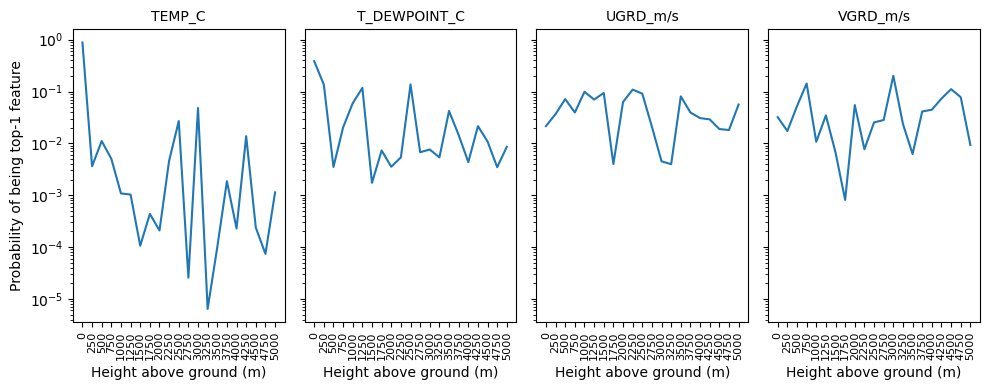

In [93]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4), sharey="row")

titles = ["TEMP_C", "T_DEWPOINT_C", "UGRD_m/s", "VGRD_m/s"]

for k, var in enumerate([conf["TEMP_C"], conf["T_DEWPOINT_C"], conf["UGRD_m/s"], conf["VGRD_m/s"]]):
    ydata = np.array([results[k] for k in var])
    axs[k].plot(var, ydata / sum(ydata))
    _var = [x.split("_")[-2] for x in var]
    _ = axs[k].set_xticks(var, _var, rotation=90, fontsize = 8)
    axs[k].set_yscale("log")
    axs[k].set_title(titles[k], fontsize = 10)

    axs[k].set_xlabel("Height above ground (m)")
axs[0].set_ylabel("Probability of being top-1 feature")
    
plt.tight_layout()